In [261]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from fealpy.decorator import cartesian
from fealpy.mesh import TriangleMesh
from fealpy.functionspace import LagrangeFiniteElementSpace
from fealpy.boundarycondition import DirichletBC

class pde():
    def __init__(self, mu=1, lam=1):
        self.mu  = mu
        self.lam = lam
        
    def domain(self):
        return [0, 1, 0, 1]
    
    def init_mesh(self, n=1, meshtype='tri'):
        node = np.array([
            (0,0),
            (1,0),
            (1,1),
            (0,1)], dtype=np.float64)
        cell = np.array([(1,2,0), (3,0,2)], dtype=np.int64)
        mesh = TriangleMesh(node, cell)
        mesh.uniform_refine(n)
        return mesh
    
    @cartesian
    def source(self, p):
        x   = p[..., 0]
        y   = p[..., 1]
        mu  = self.mu
        lam = self.lam
        
        sin = np.sin
        cos = np.cos
        val = np.zeros(p.shape, dtype=np.float64)
        
        val[..., 0] = -((2 * mu + lam) * y * (y - 1) * (2 * cos(x) - (x - 1) * sin(x))
                        + (mu + lam) * (2 * x - 1) * (sin(y) + (y - 1) * cos(y)) 
                        + 2 * mu * (x -1) * sin(x))
        val[..., 1] = -((2 * mu + lam) * x * (x - 1) * (2 * cos(y) - (y - 1) * sin(y))
                        + (mu + lam) * (2 * y - 1) * (sin(x) + (x - 1) * cos(x))
                        + 2 * mu * (y - 1) * sin(y))

        return val
    
    def dirichlet(self, p):
        var = np.zeros_like(p)
        return var
    
    def solution(self, p):
        x = p[..., 0]
        y = p[..., 1]
        
        val = np.zeros(p.shape, dtype=np.float64)
        
        val[..., 0] = y * (x - 1) * (y - 1) * np.sin(x)
        val[..., 1] = x * (x - 1) * (y - 1) * np.sin(y)
        return val
        
    def is_dirichlet_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        flag = np.max(np.abs(y)) < 1e-13 
        return flag
    
def error(u, uh):
    e = u - uh
    emax = np.max(np.abs(e))
    return emax
    
pde = pde(0.5, 0.5)
mesh = pde.init_mesh(0)
NN = mesh.number_of_nodes()
NC = mesh.number_of_cells()
#[NC,2] 剖分点及其编号(下标)
node = mesh.entity('node') 
#[NC,3] 剖分区间及其端点编号
cell = mesh.entity('cell') 
#[NC] 每个单元的面积
cm = mesh.entity_measure()

#[NC,3,2] 每个单元上基函数(三个)对x、y的偏导数
glam = mesh.grad_lambda()
GLAM = np.broadcast_to(glam[:, :, None, :], shape=[NC,3,2,2])
GLAM_T = GLAM.swapaxes(2,3)
GLAM = GLAM + GLAM_T

#[NC,3,3] 单元刚度矩阵第一部分
S = np.einsum("cnij, cmij, c->cnm", GLAM, GLAM, cm)
glam_sum = np.einsum("cni->cn", glam)
#[NC,3,3] 单元刚度矩阵第二部分
M = np.einsum("cn, cm->cnm", glam_sum, glam_sum)

I = np.broadcast_to(cell[:, :, None], shape=S.shape)
J = np.broadcast_to(cell[:, None, :], shape=S.shape)

S = csr_matrix((S.flat, (I.flat, J.flat)), shape=(NN,NN))
M = csr_matrix((M.flat, (I.flat, J.flat)), shape=(NN,NN))
A = 2 * pde.mu * S + pde.lam * M

In [262]:
def is_Bd_Node_flag():
    n = mesh.number_of_nodes()
    isBdNode = np.zeros(n, dtype=bool)
    for i in range(n):
        if (pde.is_dirichlet_boundary(mesh.node[i])):
            isBdNode[i] = True
    return isBdNode

In [263]:
from fealpy.quadrature import TriangleQuadrature

NQ = 2
Q = NQ * (NQ + 1) / 2
qf = TriangleQuadrature(NQ)

#bcs [Q,3]; WS[Q,]
bcs,ws = qf.get_quadrature_points_and_weights()
#phi [Q,3,2]
phi = np.broadcast_to(bcs[:, :, None], shape=[int(Q),3,2])

#ps [Q,NC,2]
ps = np.einsum('qi, cim->qcm', bcs, node[cell])
#val [Q,NC,2]
val = pde.source(ps)
#bb [NC,3]
bb = np.einsum('q, qcj, qij, c->ci', ws, val, phi, cm)

F = np.zeros(NN)
np.add.at(F, cell, bb)

isBdNode = mesh.ds.boundary_node_flag()
isInterNode = ~isBdNode

uh = np.zeros((NN), dtype=np.float64)
uh[isInterNode] = spsolve(A[:, isInterNode][isInterNode], F[isInterNode])

In [264]:
print("val= ", val)
print("cm= ", cm)
print("bb= ", bb)
print("F= ", F)
print("isBdNode= ", isBdNode)

val=  [[[0.86649509 0.99667997]
  [0.99667997 0.86649509]]

 [[0.37515365 0.36714926]
  [0.63990679 0.4386756 ]]

 [[0.4386756  0.63990679]
  [0.36714926 0.37515365]]]
cm=  [0.5 0.5]
bb=  [[0.2575996  0.16419359 0.19221688]
 [0.2575996  0.19221688 0.16419359]]
F=  [0.38443375 0.2575996  0.32838717 0.2575996 ]
isBdNode=  [ True  True  True  True]


In [265]:
u = pde.solution(node)
uh_ = np.broadcast_to(uh[:,None], shape=(NN,2))
e = error(u, uh_)

print('u= ', u)
print('uh= ', uh_)
print('e= ', e)

u=  [[ 0.  0.]
 [-0. -0.]
 [ 0.  0.]
 [-0. -0.]]
uh=  [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
e=  0.0


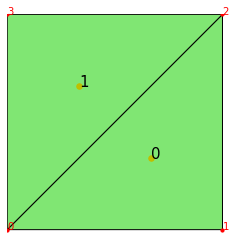

In [266]:
fig = plt.figure()
ax = fig.gca()
mesh.add_plot(ax)
mesh.find_node(ax,showindex=True)
mesh.find_cell(ax,showindex=True)

#print("NN= ", NN)
#print("NC= ", NC)
#print("glam= \n", glam)
#print("GLAM= ", GLAM)
#print("GLAM.T", GLAM_T)
#print("S= ", S.toarray())
#print("glam_sum= \n", glam_sum)
#print("M= ", M.toarray())
#print("node= ", node)
#print("cell= ", cell)
#print("I= ", I)
#print("J= ", J)

In [267]:
#scale = 10
#mesh.node[:,0] += scale*uh
#mesh.node[:,1] += scale*uh
#mesh.add_plot(plt)
#plt.show()

In [268]:
#print("bcs= ", bcs)
#print("phi= ", phi)
#print("ws= ", ws)
#print("ps= ", ps)
#print("val= ", val)
#print("node[cell]= ", node[cell])
#print("bb= ", bb)
#print("F= ", F)
#print("uh= ", uh)